# SISEPUEDE Tutorial #3 - Working with transformations

Welcome to the **SImulation of SEctoral Pathways with Uncertainty Exploration for DEcarbonization (SISEPUEDE)** tutorials! This tutorial walks users through the construction and analysis of transformations using the `Transformer`/`Transformers`, `Transformation`/`Transformations`, and `Strategy`/`Strategies` classes. By the end of this tutorial, users should be able to:

1. Access and use base `Transformer` and `Transformers` objects
2. Construct and evaluate transformations using the `Transformation` and `Transformations` classes
3. Build portfolios of policy transformations using the `Strategy` class
4. Construct and run sets of portfolios both within a notebook and using configuration (.yaml) files using the `Strategies` class

In [2]:
import warnings
warnings.filterwarnings("ignore")

import sys
path = "/Users/usuario/git/sisepuede"
if path not in sys.path:
    sys.path.append(path)

import copy
import datetime as dt
import importlib # needed so that we can reload packages
import ipywidgets as wdg
import matplotlib.pyplot as plt
import os, os.path
import numpy as np
import pandas as pd
import pathlib
import sisepuede.core.support_classes as sc
import sisepuede.transformers as trf
import sisepuede.utilities._toolbox as sf
import time
from sisepuede.manager.sisepuede_examples import SISEPUEDEExamples
from typing import Union



# Two different things: *Transformer* vs. *Transformation*




# Transformations: what are they?

Transformations are well-defined in the SISEPUEDE ecosystem. A ``Transformation`` is a parameterization of a``Transformer``. Both are classes in SISEPUEDE, with ``Transformations`` and ``Transformers`` acting as collections of these classes, respectively. Each ``Transformer`` class is a function that modifies trajectories to reflect policy outcomes; documentation for each of the 60+ functions is available on readthedocs. 

``Transformation`` objects allow users to define parameterizations of ``Transformer`` objects using configuration files in a directory. This directory contains a configuration for:

1. All transformations
1. General configuraiton and information on the baseline
1. The strategy definition file, which combines transformations



See sisepuede.readthedocs.io for more information on transformations, transformers, and strategies.



# Let's explore the objects that underly all transformations: ``Transformers``

In [3]:
help(trf.Transformers)

Help on class Transformers in module sisepuede.transformers.transformers:

class Transformers(builtins.object)
 |  Transformers(dict_config: Dict, attr_time_period: Union[str, pathlib.Path, pandas.core.frame.DataFrame, sisepuede.core.attribute_table.AttributeTable, NoneType] = None, code_baseline: str = 'TFR:BASE', df_input: Optional[pandas.core.frame.DataFrame] = None, field_region: Optional[str] = None, logger: Optional[logging.Logger] = None, regex_code_structure: re.Pattern = re.compile('TFR:(\\D*):(.*$)'), regex_template_prepend: str = 'sisepuede_run', **kwargs)
 |  
 |  Build collection of Transformers that are used to define transformations.
 |  
 |  Includes some information on
 |  
 |  Initialization Arguments
 |  ------------------------
 |  dict_config : Dict
 |      Configuration dictionary used to pass parameters to transformations. See 
 |      ?TransformerEnergy._initialize_parameters() for more information on 
 |      requirements.
 |  
 |  Optional Arguments
 |  ------

##  To get available `Transformer` classes, we need to start with a base dataset

- `Transformer` objects for SISEPUEDE are stored in the `Transformers` object
- `Transformers` requires an input data frame to transform; this data frame should be a set of raw SISEPUEDE inputs
    - Use `SISEPUEDEExamples()` to pull example data; examples are listed in `SISEPUEDEExamples.all_examples`

In [4]:
examples = SISEPUEDEExamples()
df_input = examples("input_data_frame")
# note to james -- make this a fake country name (or example_country e.g.)


In [5]:
"""fp_peru = pathlib.Path(
    "/Users/usuario/git/sisepuede_region_nbs/article_6_tanzania_sri_lanka_peru/data/sisepuede_raw_global_inputs_peru.csv"
)
df_input = pd.read_csv(fp_peru)


"""

'fp_peru = pathlib.Path(\n    "/Users/usuario/git/sisepuede_region_nbs/article_6_tanzania_sri_lanka_peru/data/sisepuede_raw_global_inputs_peru.csv"\n)\ndf_input = pd.read_csv(fp_peru)\n\n\n'

##  We can build the `Transformers` class now

In [6]:
import sisepuede.transformers.transformers as trfs
importlib.reload(trfs)
transformers = trfs.Transformers(
    {},
    df_input = df_input,  # examples("input_data_frame"),
)

# set some shortcuts
mat = transformers.model_attributes
time_periods = sc.TimePeriods(mat);
file_struct = transformers.file_struct



###  `Transformers` allows you to access all `Transformer` objects
- A `Transformer` is akin to a lever in the XLRM framework
- Each `Transformer` is associated with a variable (or set of variables) that represent a feasible, literature-based change in outcome due to at least one intervention(s)
- The list of available `Transformer` classes is available in `Transformers.all_transformers`
- Get a transformer using `Transformers.get_transformer`

In [7]:
import sisepuede.manager.sisepuede_models as sm
models = sm.SISEPUEDEModels(
    mat,
    allow_electricity_run = True,
    fp_julia = file_struct.dir_jl,
    fp_nemomod_reference_files = file_struct.dir_ref_nemo,
)

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


Precompiling NemoMod...
Info Given NemoMod was explicitly requested, output will be shown live 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
   4357.7 ms  ? NemoMod
[ Info: Precompiling NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72] 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Info: Skipping precompilation due to precompilable error. Importing NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72].
└   exception = Error when precompiling module, potentially caused by a __precompile__(false) declaration in the module.


###  A `Transformer` is callable
- When you get it, you can call it
- When called, it will generate a dataframe that is transformed under default parameters associated with each Transformer

In [6]:
transformers.all_transformers




        


['TFR:AGRC:DEC_CH4_RICE',
 'TFR:AGRC:DEC_EXPORTS',
 'TFR:AGRC:DEC_LOSSES_SUPPLY_CHAIN',
 'TFR:AGRC:INC_CONSERVATION_AGRICULTURE',
 'TFR:AGRC:INC_PRODUCTIVITY',
 'TFR:BASE',
 'TFR:CCSQ:INC_CAPTURE',
 'TFR:ENFU:ADJ_EXPORTS',
 'TFR:ENTC:DEC_LOSSES',
 'TFR:ENTC:LEAST_COST_SOLUTION',
 'TFR:ENTC:TARGET_CLEAN_HYDROGEN',
 'TFR:ENTC:TARGET_RENEWABLE_ELEC',
 'TFR:FGTV:DEC_LEAKS',
 'TFR:FGTV:INC_FLARE',
 'TFR:INEN:INC_EFFICIENCY_ENERGY',
 'TFR:INEN:INC_EFFICIENCY_PRODUCTION',
 'TFR:INEN:SHIFT_FUEL_HEAT',
 'TFR:IPPU:DEC_CLINKER',
 'TFR:IPPU:DEC_DEMAND',
 'TFR:IPPU:DEC_HFCS',
 'TFR:IPPU:DEC_N2O',
 'TFR:IPPU:DEC_OTHER_FCS',
 'TFR:IPPU:DEC_PFCS',
 'TFR:LNDU:BOUND_CLASSES',
 'TFR:LNDU:DEC_DEFORESTATION',
 'TFR:LNDU:DEC_SOC_LOSS_PASTURES',
 'TFR:LNDU:INC_REFORESTATION',
 'TFR:LNDU:INC_SILVOPASTURE',
 'TFR:LNDU:PLUR',
 'TFR:LSMM:INC_CAPTURE_BIOGAS',
 'TFR:LSMM:INC_MANAGEMENT_CATTLE_PIGS',
 'TFR:LSMM:INC_MANAGEMENT_OTHER',
 'TFR:LSMM:INC_MANAGEMENT_POULTRY',
 'TFR:LVST:DEC_ENTERIC_FERMENTATION',
 'TFR:LV

# Use the `get_transformer` method to get a transformer based on its code

In [7]:
transformers.get_transformer("TFR:AGRC:DEC_CH4_RICE")

In [8]:
#tr_reduce_rice_methane.attribute_transformer_code
tr_reduce_rice_methane.description

NameError: name 'tr_reduce_rice_methane' is not defined

In [9]:
tr_reduce_rice_methane = transformers.get_transformer("TFR:AGRC:DEC_CH4_RICE")

# you can call it 
df_input_reduce_rice = tr_reduce_rice_methane()
df_input_reduce_rice


,region,time_period,avgload_trns_freight_tonne_per_vehicle_aviation,avgload_trns_freight_tonne_per_vehicle_rail_freight,avgload_trns_freight_tonne_per_vehicle_road_heavy_freight,avgload_trns_freight_tonne_per_vehicle_water_borne,avgmass_lvst_animal_buffalo_kg,avgmass_lvst_animal_cattle_dairy_kg,avgmass_lvst_animal_cattle_nondairy_kg,avgmass_lvst_animal_chickens_kg,...,ef_lndu_conv_wetlands_to_forests_primary_gg_co2_ha,ef_lndu_conv_wetlands_to_forests_secondary_gg_co2_ha,ef_lndu_conv_wetlands_to_grasslands_gg_co2_ha,ef_lndu_conv_wetlands_to_other_gg_co2_ha,ef_lndu_conv_wetlands_to_pastures_gg_co2_ha,ef_lndu_conv_wetlands_to_settlements_gg_co2_ha,ef_lndu_conv_wetlands_to_shrublands_gg_co2_ha,ef_lndu_conv_wetlands_to_wetlands_gg_co2_ha,gasrf_lsmm_biogas_anaerobic_lagoon,energydensity_gravimetric_enfu_gj_per_tonne_fuel_natural_gas
0,costa_rica,0,70.0,2923.0,31.751466,6468.0,322.900664,520.741388,310.599686,1.12759,...,0.0,0.0,0.0,0.003030,0.0,0.003030,0.0,0.0,0.0,47.9
1,costa_rica,1,70.0,2923.0,31.751466,6468.0,322.900664,520.741388,310.599686,1.12759,...,0.0,0.0,0.0,0.003010,0.0,0.003010,0.0,0.0,0.0,47.9
2,costa_rica,2,70.0,2923.0,31.751466,6468.0,322.900664,520.741388,310.599686,1.12759,...,0.0,0.0,0.0,0.002960,0.0,0.002960,0.0,0.0,0.0,47.9
3,costa_rica,3,70.0,2923.0,31.751466,6468.0,322.900664,520.741388,310.599686,1.12759,...,0.0,0.0,0.0,0.002949,0.0,0.002949,0.0,0.0,0.0,47.9
4,costa_rica,4,70.0,2923.0,31.751466,6468.0,322.900664,520.741388,310.599686,1.12759,...,0.0,0.0,0.0,0.002949,0.0,0.002949,0.0,0.0,0.0,47.9
5,costa_rica,5,70.0,2923.0,31.751466,6468.0,322.900664,520.741388,310.599686,1.12759,...,0.0,0.0,0.0,0.002980,0.0,0.002980,0.0,0.0,0.0,47.9
6,costa_rica,6,70.0,4082.0,31.751466,6468.0,322.900664,520.741388,310.599686,1.12759,...,0.0,0.0,0.0,0.002980,0.0,0.002980,0.0,0.0,0.0,47.9
7,costa_rica,7,70.0,4082.0,31.751466,6468.0,322.900664,520.741388,310.599686,1.12759,...,0.0,0.0,0.0,0.002980,0.0,0.002980,0.0,0.0,0.0,47.9
8,costa_rica,8,70.0,4082.0,31.751466,6468.0,322.900664,520.741388,310.599686,1.12759,...,0.0,0.0,0.0,0.002980,0.0,0.002980,0.0,0.0,0.0,47.9
9,costa_rica,9,70.0,4082.0,31.751466,6468.0,322.900664,520.741388,310.599686,1.12759,...,0.0,0.0,0.0,0.002980,0.0,0.002980,0.0,0.0,0.0,47.9


In [10]:
import sisepuede.models.afolu as mafl
model_afolu = mafl.AFOLU(mat, )





In [34]:
tr_baseline = transformers.get_transformer("TFR:BASE")
df_baseline = tr_baseline()

df_emissions_untransformed = model_afolu(df_baseline, )
df_emissions_transformed = model_afolu(df_input_reduce_rice)

<Axes: >

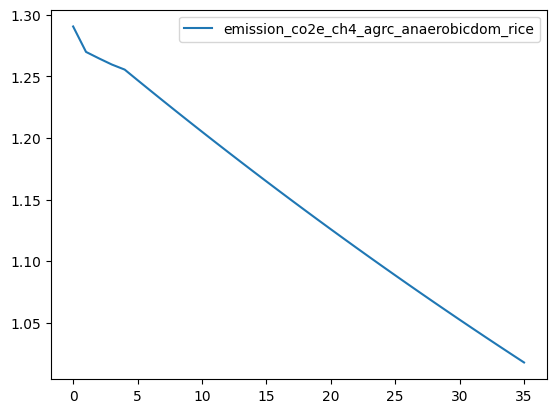

In [37]:
df_emissions_untransformed[[x for x in df_emissions_untransformed.columns if "ch4" in x and "rice" in x]].plot()

In [41]:
?tr_reduce_rice_methane

Signature:       tr_reduce_rice_methane(*args, **kwargs) -> Any
Type:            Transformer
String form:     <sisepuede.transformers.transformers.Transformer object at 0x12e775f90>
File:            ~/git/sisepuede/sisepuede/transformers/transformers.py
Docstring:      
Implement the "Improve Rice Management" AGRC transformer on input DataFrame df_input. 

Transformation Code : 
        TFR:AGRC:DEC_CH4_RICE

Parameters
----------
df_input : pd.DataFrame
    Optional data frame containing trajectories to modify
magnitude : float
    Minimum target fraction of rice production under improved management.
strat : int
    Optional strategy value to specify for the transformation
vec_implementation_ramp : Union[np.ndarray, Dict[str, int], None]
    Optional vector or dictionary specifying the implementation scalar ramp for the transformation. If None, defaults to a uniform ramp that starts at the time specified in the configuration.
Class docstring:
Create a Transformation class to support c

<Axes: >

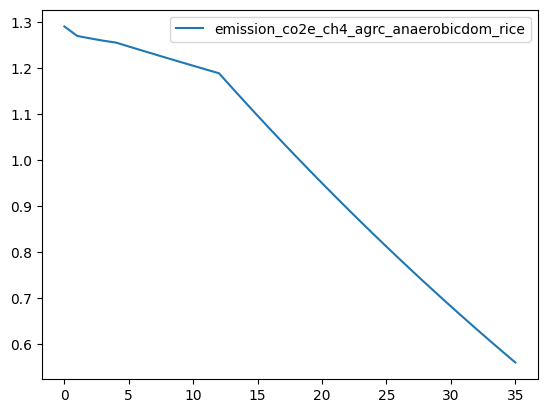

In [44]:
df_input_reduce_rice = tr_reduce_rice_methane()#magnitude = 0.45)
df_emissions_transformed = model_afolu(df_input_reduce_rice)
df_emissions_transformed[[x for x in df_emissions_transformed.columns if "ch4" in x and "rice" in x]].plot()

In [36]:
[x for x in dir(transformers.model_enercons) if "modvar_trns" in x]

modvar = transformers.model_enercons.modvar_trns_fuel_fraction_electricity
modvar = mat.get_variable(modvar)
modvar.get_from_dataframe(df).tail()



,frac_trns_fuelmix_aviation_electricity,frac_trns_fuelmix_powered_bikes_electricity,frac_trns_fuelmix_public_electricity,frac_trns_fuelmix_rail_freight_electricity,frac_trns_fuelmix_rail_passenger_electricity,frac_trns_fuelmix_road_heavy_freight_electricity,frac_trns_fuelmix_road_heavy_regional_electricity,frac_trns_fuelmix_road_light_electricity,frac_trns_fuelmix_water_borne_electricity
31,0.0,0.549988,0.564754,0.0,0.522293,0.564754,0.564754,0.006473,0.0
32,0.0,0.549988,0.594128,0.0,0.522293,0.594128,0.594128,0.006380,0.0
33,0.0,0.549988,0.623511,0.0,0.522293,0.623511,0.623511,0.006290,0.0
34,0.0,0.549988,0.652901,0.0,0.522293,0.652901,0.652901,0.006203,0.0
35,0.0,0.549988,0.682299,0.0,0.522293,0.682299,0.682299,0.006120,0.0


In [37]:
modvar.get_from_dataframe(df_input).tail()

,frac_trns_fuelmix_aviation_electricity,frac_trns_fuelmix_powered_bikes_electricity,frac_trns_fuelmix_public_electricity,frac_trns_fuelmix_rail_freight_electricity,frac_trns_fuelmix_rail_passenger_electricity,frac_trns_fuelmix_road_heavy_freight_electricity,frac_trns_fuelmix_road_heavy_regional_electricity,frac_trns_fuelmix_road_light_electricity,frac_trns_fuelmix_water_borne_electricity
31,0.0,0.549988,0.006414,0.0,0.522293,0.006414,0.006414,0.006473,0.0
32,0.0,0.549988,0.006323,0.0,0.522293,0.006323,0.006323,0.006380,0.0
33,0.0,0.549988,0.006234,0.0,0.522293,0.006234,0.006234,0.006290,0.0
34,0.0,0.549988,0.006150,0.0,0.522293,0.006150,0.006150,0.006203,0.0
35,0.0,0.549988,0.006068,0.0,0.522293,0.006068,0.006068,0.006120,0.0


In [38]:
df_input[[x for x in df_input.columns if x.startswith("frac_trns_fuelmix_public_")]].tail()

,frac_trns_fuelmix_public_diesel,frac_trns_fuelmix_public_natural_gas,frac_trns_fuelmix_public_electricity,frac_trns_fuelmix_public_gasoline,frac_trns_fuelmix_public_biofuels,frac_trns_fuelmix_public_hydrogen,frac_trns_fuelmix_public_hydrocarbon_gas_liquids
31,0.319624,0.009144,0.006414,0.643903,0.020915,0.0,0.0
32,0.317855,0.008970,0.006323,0.646339,0.020513,0.0,0.0
33,0.316155,0.008803,0.006234,0.648679,0.020128,0.0,0.0
34,0.314522,0.008642,0.006150,0.650929,0.019757,0.0,0.0
35,0.312950,0.008488,0.006068,0.653093,0.019400,0.0,0.0


###  A `Transfomer` is parameterized using keyword arguments
- No need to pass `df_input` unless you want to apply it to a data frame not used to instantiation the `Transformers` collection
- However, other arguments can be varied
- Full documentation of all `Transformer` functions is available at the [SISEPUEDE readthedocs](https://sisepuede.readthedocs.io/en/latest/transformers.html)
- Let's look at the doc string of `tr_medium_duty.function`, the base function in the transformer that we called (can also use `?tr_medium_duty`, but it will not show the signature)
    - `categories` can be varied to any TRNS category
    - `dict_allocation_fuels_target` is used to allocate the magnitude of the fuel shift across target fuels; 
        - `dict_allocation_fuels_target = {"fuel_electricity": 1.0}` means that 100% of the magnitude will be shifted away from `fuels_source`to electricity
    - `fuels_source` give fuels that are shifted away from. By default, this `Transformer` only shifts away from diesel and gas
    - `magnitude`: fraction of source fuel mix that is shifted to fuels specified in `dict_allocation_fuels_target`
    - `vec_implementation_ramp`: the implementation ramp vector. See discussion below for more information on how this can be specified

In [49]:
?tr_medium_duty.function



Signature:
tr_medium_duty.function(
    categories: List[str] = ['road_heavy_freight', 'road_heavy_regional', 'public'],
    dict_allocation_fuels_target: Optional[dict] = None,
    df_input: Optional[pandas.core.frame.DataFrame] = None,
    fuels_source: List[str] = ['fuel_diesel', 'fuel_gasoline'],
    magnitude: float = 0.7,
    strat: Optional[int] = None,
    vec_implementation_ramp: Optional[numpy.ndarray] = None,
) -> pandas.core.frame.DataFrame
Docstring:
Implement the "Fuel-Switch Medium Duty" TRNS transformer on input DataFrame df_input. By default, transfers mangitude to electricity from gasoline and diesel; e.g., with magnitude = 0.7, then 70% of diesel and gas demand are transfered to fuels in fuels_target. The rest of the fuel demand is then transferred to hydrogen. 

Parameters
----------
categories : List[str]
    Transportation categories to include; defaults to 
    [
        "road_heavy_freight", 
        "road_heavy_regional", 
        "public"
    ]
dict_allocation

# Now, let's examine `Transformation` classes

- A `Transformation` is a parameterization of a `Transformer`
- Let's look at fuel shifting medium-duty
- A `Transformation` can be defined using a dictionary or a configuration file. 
    - **NOTE**: A value of `None` can be passed in a YAML configuration using `null`


-----

#### For this example, we'll walk through a dictionary. 

The following keys are required in a dictionary/yaml file:

- `citations`: list of bibtex citations to call. These bibtex citations can be in the default SISEPUEDE library `sisepuede/docs/source/citations.bib` or provided in a Transformation definition directory in `citations.bib`
- `description`: optional description to provide. 
    - **NOTE**: Descriptions can be include citations as \\cite{CITEKEY}
- `identifiers` (**required**): 
    - `transformation_code` (**required**): specify a transformation code. These codes are used to define strategies. **NOTE: CANNOT CONTAIN "|" CHARACTER**
    - `transformation_name` (optional): optional name for the transformation, but it is recommended to provide one. This name is used in building automated reports and display tables.
- `parameters` (**required**): Parameters--or keyword arguments to the function--are passed as a dictionary associated with this key. 
    - Parameters included in here *must* be keyword arguments to the `Transformer` that will be parameterized
- `transformer` (**required**): The `Transformer` code that this transformation will parameterize. 
        

In [10]:
# Default setup
dict_setup = {
    "citations": ["autho_123", "xbm"],
    "identifiers": {
        "transformation_code": "TX:TRNS:SHIFT_FUEL_MEDIUM_DUTY",
        "transformation_name": "Shift fuel for medium duty vehicles"
    },
    "description": "This came from this paper and that came from that paper",
    "parameters": {
        "categories": [
            "road_heavy_freight",
            "road_heavy_regional",
            "public"
        ],
        "dict_allocation_fuels_target": None,
        "fuels_source": [
            "fuel_diesel", 
            "fuel_gasoline"
        ],
        "magnitude": 0.5,
        "vec_implementation_ramp": {
            "alpha_logistic": 0,
            "n_tp_ramp": None,
            "tp_0_ramp": None,
            "window_logistic": [-8, 8]
        }
    },
    "transformer": "TFR:TRNS:SHIFT_FUEL_MEDIUM_DUTY"
}


# built the Transformation using dict_setup
transformation_1 = trf.Transformation(
    dict_setup,
    transformers,
)



# Default setup
dict_setup_2 = {
    "citations": ["autho_123", "xbm"],
    "identifiers": {
        "transformation_code": "TX:TRNS:SHIFT_FUEL_MEDIUM_DUTY_LOW",
        "transformation_name": "Shift fuel for medium duty vehicles at a lower intensity"
    },
    "description": "This came from this paper and that came from that paper",
    "parameters": {
        "categories": [
            "road_heavy_freight",
            "road_heavy_regional",
            "public"
        ],
        "dict_allocation_fuels_target": None,
        "fuels_source": [
            "fuel_diesel", 
            "fuel_gasoline"
        ],
        "magnitude": 0.3,
        "vec_implementation_ramp": {
            "alpha_logistic": 0,
            "n_tp_ramp": None,
            "tp_0_ramp": None,
            "window_logistic": [-8, 8]
        }
    },
    "transformer": "TFR:TRNS:SHIFT_FUEL_MEDIUM_DUTY"
}


# built the Transformation using dict_setup
transformation_1 = trf.Transformation(
    dict_setup,
    transformers,
)

transformation_2 = trf.Transformation(
    dict_setup_2,
    transformers,
)

# Look at the transformed variables for one of the categories

The transformation shifts fuel sources for three categories--`road_heavy_freight`, `road_heavy_regional`, and `public`--into electricity and hydrogen. Let's look at fuel fractions under two conditions--without the tranformation + with the transformation-for only the `public` transportation category.

<Axes: title={'center': 'Transformation 1 Inputs'}>

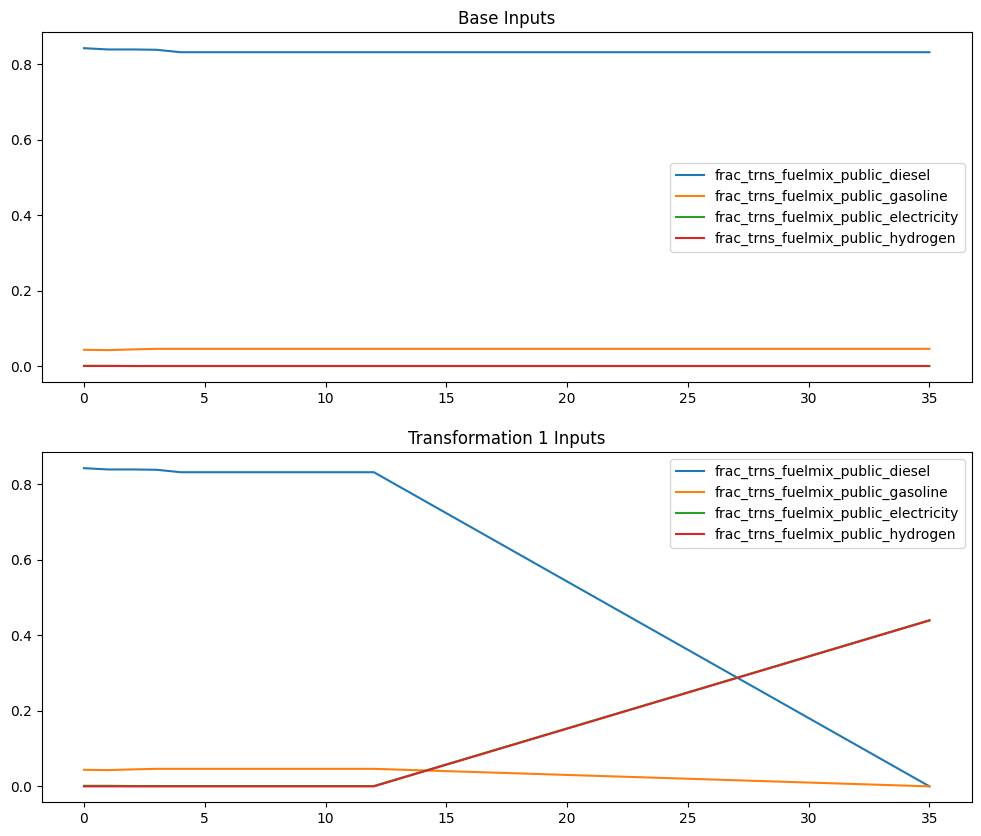

In [11]:
# First, let's build the fields
cats = ["public"]
fields = []

for fuel_name in ["Diesel", "Gasoline", "Electricity", "Hydrogen"]:
    fields += mat.build_variable_fields(
        f"Transportation Mode Fuel Fraction {fuel_name}",
        restrict_to_category_values = cats,
    )


# execute the transformation (can also use transformation_1.function())
df_input_transformation_1 = transformation_1()

# build a plot
fig, ax = plt.subplots(2, 1, figsize = (12, 10))

# base
ax[0].set_title("Base Inputs")
df_input[fields].plot(ax = ax[0])

# transformed
ax[1].set_title("Transformation 1 Inputs")
df_input_transformation_1[fields].plot(ax = ax[1])

<Axes: title={'center': 'Transformation 1 Inputs'}>

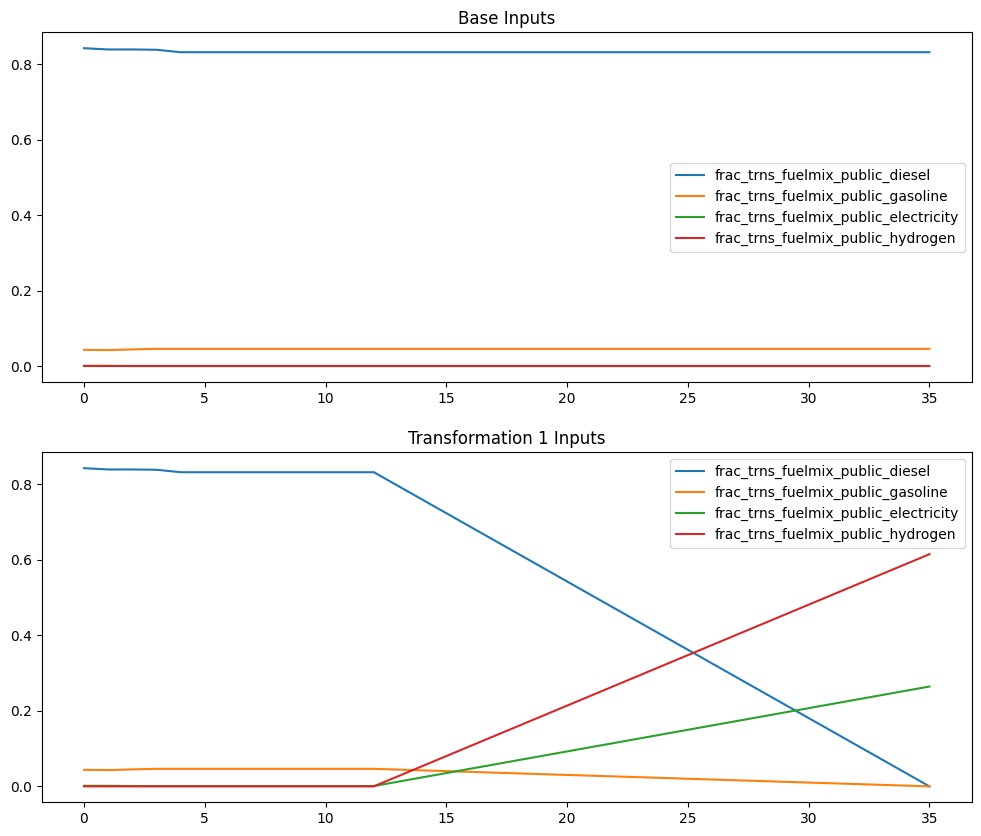

In [12]:
# First, let's build the fields
cats = ["public"]
fields = []

for fuel_name in ["Diesel", "Gasoline", "Electricity", "Hydrogen"]:
    fields += mat.build_variable_fields(
        f"Transportation Mode Fuel Fraction {fuel_name}",
        restrict_to_category_values = cats,
    )


# execute the transformation (can also use transformation_1.function())
df_input_transformation_2 = transformation_2()

# build a plot
fig, ax = plt.subplots(2, 1, figsize = (12, 10))

# base
ax[0].set_title("Base Inputs")
df_input[fields].plot(ax = ax[0])

# transformed
ax[1].set_title("Transformation 1 Inputs")
df_input_transformation_2[fields].plot(ax = ax[1])

##  There are 2 approaches available to change the timing or shape of the implementation ramp

The `implementation_ramp` is commonly specified using `vec_implementation_ramp` across SISEPUEDE. 

- The implementation ramp represents what fraction of the magnitude of a transformation is implemented across time. It takes values in [0, 1] and must have the same length as the original data
- If not specified, it defaults to start at the current year + 2 and end at the final time period
- **IMPORTANT NOTE**: When building Transformation directories, you can specify a default `vec_implementation_ramp` in the general config (under the `general` key); one for the baseline (under the `baseline` key in config_general); and, if desired, a unique one for any of the Transformations in the directory. In these configuration files--as with setup dictionaries--`vec_implementation` can be specified as a dictionary or a vector of values.

----


###  Approach 1: set the implementation ramp using a dictionary (preferred approach)
 

Let's demonstrate one approach to setting the implementation ramp. First, we can build one using parameters in a dictionary. The key parameters are:

- `alpha` (mix fraction): fraction of the ramp that is logistic. For all linear, set to 0.0; for completely logistic, set to 1.0
- `tp_0_ramp`: final time period == 0 in the ramp
- `window_logistic`: $(w_0, w_1)$ the window of the standard logit function [ $f(x) = (1 + e^{-x})^{-1}$ ] used to create the shape. In general, the min and max should be symmetric:
     - if $|w_0| < |w_1|$ and $w_0 < 0, w_1 > 0$, then the ramp will grow quickly and reach near-full implementation early; 
     - if $|w_0| > |w_1|$ and $w_0 < 0, w_1 > 0$, then the ramp will grow slowly and reach near-full implementation late; 
- `d` (not in interactive): value where logit == 0.5. For advanced use.

```
{
    "vec_implementation_ramp": {
        "alpha_logistic": alpha,
        "n_tp_ramp": len(time_periods.all_time_periods),
        "tp_0_ramp": tp_0_ramp,
        "window_logistic": (window_min, window_max)
    }
}
```

----

##  Now, we can interact with a widget to explore how these shape parameters change the implementation ramp


In [13]:
def interactive_df_plot(
    df: pd.DataFrame,
    fields_plot: list,
) -> wdg.interactive:
    """
    Build an interactive ipywidget time seris plot for df. Will ignore fields specified
        in `fields_ignore`.
    """
    
    # build some widgets
    slider_alpha = wdg.FloatSlider(
        description = "$\\alpha$",
        min = 0.0, 
        max = 1.0, 
        step = 0.01,
        value = 0.0,
    )
    slider_tp_0 = wdg.IntSlider(
        description = "$t_0^{(ramp)}$",
        min = min(time_periods.all_time_periods), 
        max = max(time_periods.all_time_periods),
        value = (dt.datetime.now().year + 2 - time_periods.all_years[0]) # default
    )
    slider_window_max = wdg.FloatSlider(
        description = "$w_{max}$",
        max = 10.0,
        min = 0.0, 
        value = 8.0,
    )
    slider_window_min = wdg.FloatSlider(
        description = "$w_{min}$",
        max = 0.0,
        min = -10.0, 
        value = -8.0,
    )
        

    # placeholder for other actions
    df_plot = df

    # function to allow interaction
    def show_transformation(
        alpha: float,
        tp_0_ramp: int,
        window_max: float,
        window_min: float,
    ) -> 'plt.plot()':
        """
        Plot output fields from the model run on the df_model_data data frame
        """
        

        # update
        dict_setup_cur = copy.deepcopy(dict_setup)
        (
            dict_setup_cur
            .get("parameters")
            .update(
                {
                    "vec_implementation_ramp": {
                        "alpha_logistic": alpha,
                        "n_tp_ramp": len(time_periods.all_time_periods),
                        "tp_0_ramp": tp_0_ramp,
                        "window_logistic": (window_min, window_max)
                    }
                }
            )
        )


        # build a new transformation with the implementation ramp
        transformation_cur = trf.Transformation(
            dict_setup_cur,
            transformers,
        )

        # execute the transformation and plot (can also use transformation_1.function())
        df_input_transformation_cur = transformation_cur()
        
        # initialize plot
        fig, ax = plt.subplots(1, 1, figsize = (12, 6))
        ax.set_title("Transformation with modified vec_implementation_ramp")
        df_input_transformation_cur[fields_plot].plot(ax = ax, )
        
        plt.show()

        return None
    
    

    out = wdg.interactive(
        show_transformation,
        alpha = slider_alpha,
        tp_0_ramp = slider_tp_0,
        window_max = slider_window_max,
        window_min = slider_window_min,
    )

    return out


interactive_df_plot(
    df_input,
    fields,
)

interactive(children=(FloatSlider(value=0.0, description='$\\alpha$', max=1.0, step=0.01), IntSlider(value=12,…

###  We can read more about the parameters in the `_toolbox` function `ramp_vector`

In [45]:
# check the characteristics of ramp vector
?sf.ramp_vector

Signature:
sf.ramp_vector(
    n: int,
    alpha_logistic: float = 0.0,
    d: Union[float, int] = 0,
    r_0: int = 0,
    r_1: Optional[int] = None,
    window_logistic: Tuple[int, int] = (-8, 8),
) -> float
Docstring:
Build a ramp vector for n time periods. Allows for the specifcation of a 
    linear vector, sigmoid, window within sigmoid, or some mix of the two.
    

Function Arguments
------------------
n : int
    Number of time periods (total)

Keyword Arguments
-----------------
alpha_logistic : float
    Fraction of ramp function that is associated with the logistic. 
    (1 - alpha_logistic) gives the fraction that is linear.
d : Union[float, int]
    Centroid for logistic function in window
r_0 : int
    Last period == 0; e.g., if r_0 = 4 and n = 10, then in a linear 
    function, we have
r_1 : Union[int, None]
    First period == 1. If None, defaults to n
window_logistic : 
    Window in standard logistic function (i.e., 1/(1 + e^(-x)) that is 
    shifted and stretched 

###  Approach 2: directly set the implementation ramp

Another approach to setting the implementation ramp is to to build one from scratch. It must take values in [0, 1], start with 0, and end with 1. This approach can be useful for non-traditional curves, or for a symmetric benchmarks that must be met over time. 

The time periods in the example range from 0-35 (2015 to 2050); let's suppose we have a transformation that begins in 2030 (the last value == 0 in this case) with 80% implemenation by 2040 and 100% by 2050. 

``vec_implementation_ramp = np.concatenate([np.zeros(16), np.arange(1, 11)*0.08, np.arange(1, 11)*0.02 + 0.8])``

**NOTE**: the toolbox (`sisepuede.utilities._toolbox`) includes the `ramp_vector` function, which is extremely useful for building vectors from scratch.

<Axes: title={'center': 'Transformation 2 Data'}>

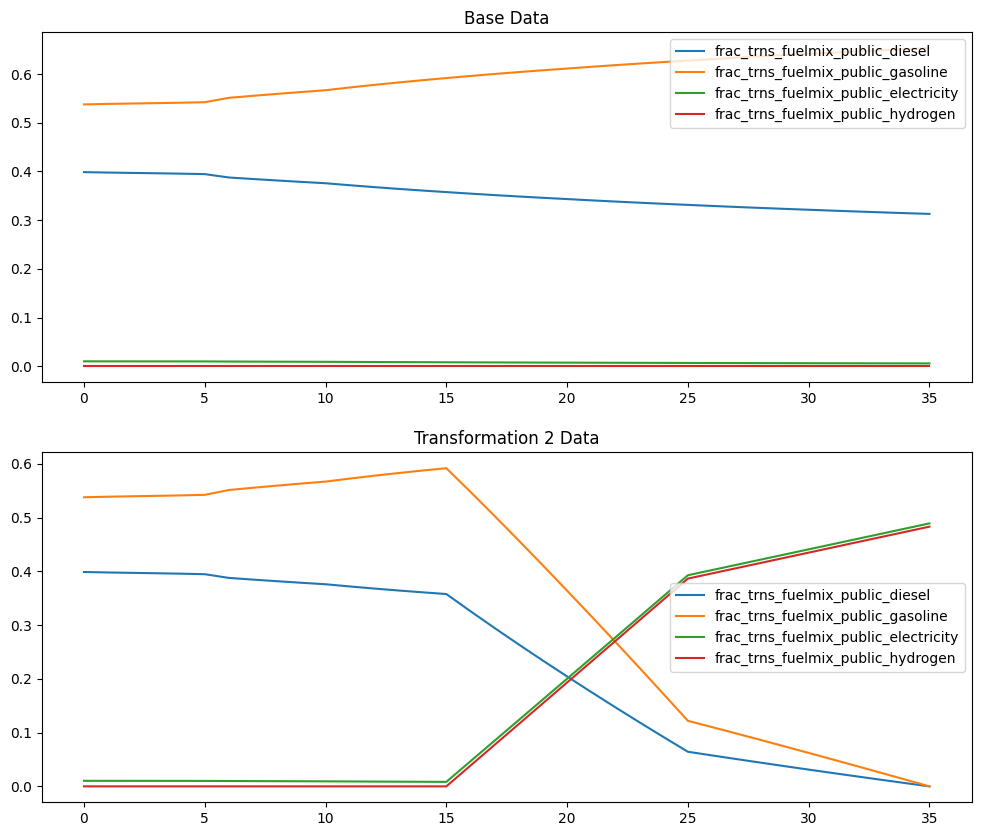

In [46]:
# set the vector--should be a numpy array
vec_implementation_ramp = np.concatenate(
    [
        np.zeros(16),
        np.arange(1, 11)*0.08,
        np.arange(1, 11)*0.02 + 0.8
    ]
)

# update
dict_setup_2 = copy.deepcopy(dict_setup)
dict_setup_2.get("parameters").update({"vec_implementation_ramp": vec_implementation_ramp})



# build a new transformation with the implementation ramp
transformation_2 = trf.Transformation(
    dict_setup_2,
    transformers,
)

# execute the transformation (can also use transformation_1.function())
df_input_transformation_2 = transformation_2()

fig, ax = plt.subplots(2, 1, figsize = (12, 10))

# base
ax[0].set_title("Base Data")
df_input[fields].plot(ax = ax[0])

# transformed
ax[1].set_title("Transformation 2 Data")
df_input_transformation_2[fields].plot(ax = ax[1])

# How do we define a `Transformations` object (which are required to build `Strategies`)?
- `Transformations` are collections of `Transformation` objects
- They are defined in collections of configuration files stored in a _Strategy Directory_
    - The _Strategy Directory_ contains information about transformations, strategic combinations, and even citations
- The easiest way to begin is to instantiate a default strategy directory;
    - It will export one `Transformation` YAML configuration file for each `Transformer` object and prepopulate with defaults. From there, you can modify parameters or duplicate as needed. 
    - Each Transformation **must** have a unique Transformation code to be counted
    - Note that there can be multiple `Transformation` files associated with a single `Transformer`
    - A default strategy definition file is also created that includes:
        - Base case (required)
        - All singleton strategies (1:1 mapping with `Transformation` objects that are defined)
        - Sectoral combinations (the instantation chooses one `Transformation` per `Transformer` to include)
        - All (using the same one `Transformation` per `Transformer`)

In [61]:
trf.Transformation(
    config = {
        "parameters": {
            "vec_implementation_ramp": {
                "tp_0_ramp": 5,
            }
        }
    },
    transformers,
)

IndentationError: unexpected indent (4266885827.py, line 2)

In [11]:
# set an ouput path and instantiate
dir_transformations_out = "/Users/usuario/Desktop/transformations_default"
if True:#not os.path.exists(dir_transformations_out):
    trf.instantiate_default_strategy_directory(
        transformers,
        dir_transformations_out,
    )


In [12]:
# then, you can load this back in after modifying (play around with it)
transformations = trf.Transformations(
    dir_transformations_out,
    transformers = transformers,
)
tab = transformations.attribute_transformation.table
tab


,transformation_id,transformation_code,transformation_name,description,citations,path
0,0,TX:BASE,None,None,None,None
1,1,TX:AGRC:DEC_CH4_RICE,Default Value - AGRC: Improve rice management,Reduce :math:`\text{CH}_4` emissions from rice...,None,/Users/usuario/Desktop/transformations_default...
2,2,TX:AGRC:DEC_EXPORTS,Default Value - AGRC: Decrease Exports,Decrease agricultural exports by 50% (relative...,None,/Users/usuario/Desktop/transformations_default...
3,3,TX:AGRC:DEC_LOSSES_SUPPLY_CHAIN,Default Value - AGRC: Reduce supply chain losses,Reduce waste food waste in the agricultural (c...,None,/Users/usuario/Desktop/transformations_default...
4,4,TX:AGRC:INC_CONSERVATION_AGRICULTURE,Default Value - AGRC: Expand conservation agri...,| Decrease soil organic carbon loss in cropla...,None,/Users/usuario/Desktop/transformations_default...
...,...,...,...,...,...,...
63,63,TX:WASO:INC_CAPTURE_BIOGAS,Default Value - WASO: Increase biogas capture,Increase fraction of biogas captured from land...,None,/Users/usuario/Desktop/transformations_default...
64,64,TX:WASO:INC_ENERGY_FROM_BIOGAS,Default Value - WASO: Biogas for energy produc...,Increase the fraction of biogas that is collec...,None,/Users/usuario/Desktop/transformations_default...
65,65,TX:WASO:INC_ENERGY_FROM_INCINERATION,Default Value - WASO: Incineration for energy ...,None,None,/Users/usuario/Desktop/transformations_default...
66,66,TX:WASO:INC_LANDFILLING,Default Value - WASO: Increase landfilling,Increase fraction of waste that is otherwise u...,None,/Users/usuario/Desktop/transformations_default...


In [61]:
# look at all codes that were accepts
transformations.all_transformation_codes

['TX:AGRC:DEC_CH4_RICE',
 'TX:AGRC:DEC_EXPORTS',
 'TX:AGRC:DEC_LOSSES_SUPPLY_CHAIN',
 'TX:AGRC:INC_CONSERVATION_AGRICULTURE',
 'TX:AGRC:INC_PRODUCTIVITY',
 'TX:BASE',
 'TX:CCSQ:INC_CAPTURE',
 'TX:ENFU:ADJ_EXPORTS',
 'TX:ENTC:DEC_LOSSES',
 'TX:ENTC:LEAST_COST_SOLUTION',
 'TX:ENTC:TARGET_CLEAN_HYDROGEN',
 'TX:ENTC:TARGET_RENEWABLE_ELEC',
 'TX:FGTV:DEC_LEAKS',
 'TX:FGTV:INC_FLARE',
 'TX:INEN:INC_EFFICIENCY_ENERGY',
 'TX:INEN:INC_EFFICIENCY_PRODUCTION',
 'TX:INEN:SHIFT_FUEL_HEAT',
 'TX:IPPU:DEC_CLINKER',
 'TX:IPPU:DEC_DEMAND',
 'TX:IPPU:DEC_HFCS',
 'TX:IPPU:DEC_N2O',
 'TX:IPPU:DEC_OTHER_FCS',
 'TX:IPPU:DEC_PFCS',
 'TX:LNDU:BOUND_CLASSES',
 'TX:LNDU:DEC_DEFORESTATION',
 'TX:LNDU:DEC_DEFORESTATION_LIGHT',
 'TX:LNDU:DEC_SOC_LOSS_PASTURES',
 'TX:LNDU:INC_REFORESTATION',
 'TX:LNDU:INC_SILVOPASTURE',
 'TX:LNDU:PLUR',
 'TX:LSMM:INC_CAPTURE_BIOGAS',
 'TX:LSMM:INC_MANAGEMENT_CATTLE_PIGS',
 'TX:LSMM:INC_MANAGEMENT_OTHER',
 'TX:LSMM:INC_MANAGEMENT_POULTRY',
 'TX:LVST:DEC_ENTERIC_FERMENTATION',
 'TX:L

In [73]:
# explore transformations
tr_dec_deforestation = transformations.get_transformation("TX:LNDU:DEC_DEFORESTATION")
df_dec_deforestation = tr_dec_deforestation()
df_dec_deforestation["lndu_reallocation_factor"] = 1
df_out_dec_deforestation = model_afolu(df_dec_deforestation)

tr_dec_deforestation_light = transformations.get_transformation("TX:LNDU:DEC_DEFORESTATION_LIGHT")
df_dec_deforestation_light = tr_dec_deforestation_light()
df_dec_deforestation_light["lndu_reallocation_factor"] = 1
df_out_dec_deforestation_light = model_afolu(df_dec_deforestation_light)


<Axes: >

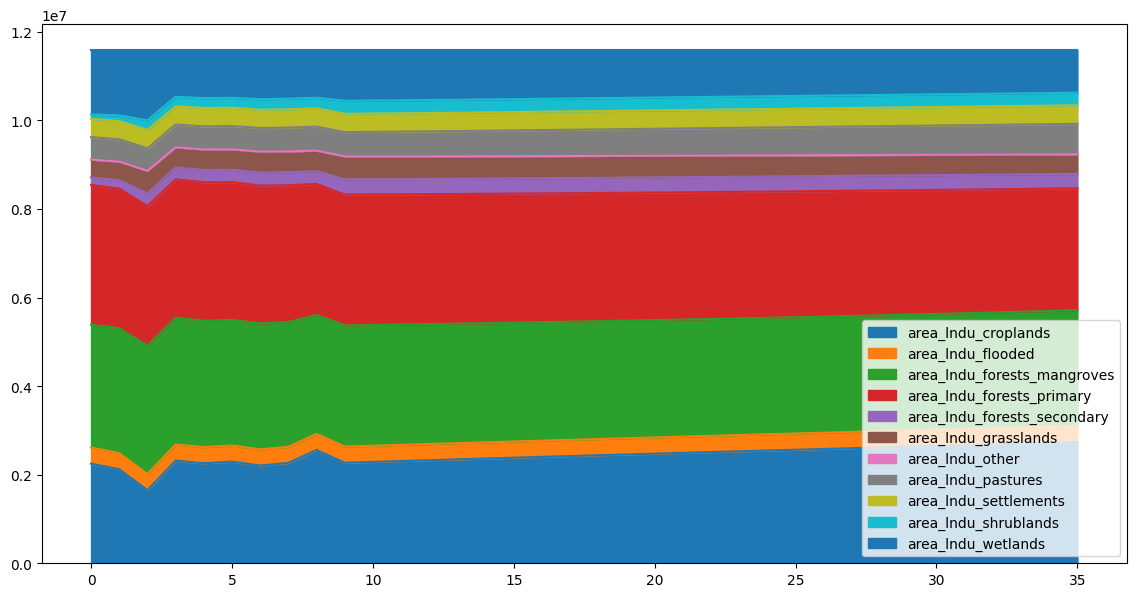

In [74]:
modvar = mat.get_variable("Land Use Area")

fig, ax = plt.subplots(figsize = (14, 7))
modvar.get_from_dataframe(df_out_dec_deforestation).plot.area(ax = ax)


<Axes: >

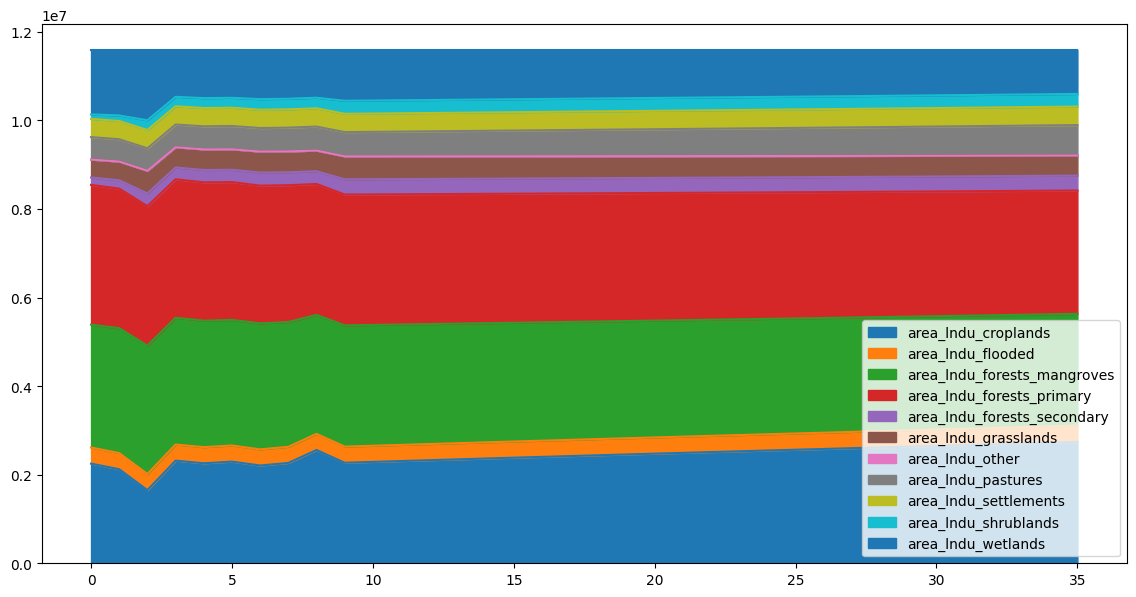

In [75]:
modvar = mat.get_variable("Land Use Area")

fig, ax = plt.subplots(figsize = (14, 7))
modvar.get_from_dataframe(df_out_dec_deforestation_light).plot.area(ax = ax)



# Next, let's build some individual strategies
- A `Strategy` is a combination of `Transformations`; this approach allows for extensive variation in parameterization--including timing, magnitude, and categorization--of `Transformers`.
- A `Strategy` requires the following to be instatiated:
    - `strategy_id`
    - `transformation_specification`: If None or "", returns baseline strategy. Otherwise, can be a list of `Transformation` codes OR a pipe (i.e., "|") -delimited string
    - `Transformations` object used to combine `Transformation` functions
- Similar to a `Transformation`, a `Strategy` is callable

In [13]:
# a baseline strategy can be instantiated without 
strat = trf.Strategy(
    0,
    None,
    transformations,
)


strat1 = trf.Strategy(
    1,
    ["TX:LSMM:INC_MANAGEMENT_CATTLE_PIGS", "TX:LSMM:INC_CAPTURE_BIOGAS"],
    transformations,
)

strat2 = trf.Strategy(
    2,
    "TX:TRNS:SHIFT_FUEL_MEDIUM_DUTY|ENTC:TARGET_RENEWABLE_ELEC",
    transformations
)


In [77]:
df = strat2()
df[[x for x in df.columns if x.startswith("frac_trns_fuelmix_road_heavy_freight")]].tail()

,frac_trns_fuelmix_road_heavy_freight_hydrocarbon_gas_liquids,frac_trns_fuelmix_road_heavy_freight_biofuels,frac_trns_fuelmix_road_heavy_freight_diesel,frac_trns_fuelmix_road_heavy_freight_electricity,frac_trns_fuelmix_road_heavy_freight_gasoline,frac_trns_fuelmix_road_heavy_freight_hydrogen,frac_trns_fuelmix_road_heavy_freight_natural_gas
31,0.0,0.0,0.155856,0.576335,0.017478,0.247001,0.003331
32,0.0,0.0,0.116892,0.606668,0.013109,0.260001,0.003331
33,0.0,0.0,0.077928,0.637002,0.008739,0.273001,0.003331
34,0.0,0.0,0.038964,0.667335,0.004370,0.286001,0.003331
35,0.0,0.0,0.000000,0.697668,0.000000,0.299001,0.003331


##  Similar to a `Transformation` and `Transformer`, a `Strategy` is callable
- Note that it is pre-populated with the `strategy_id` (the field associated with `model_attributes.dim_strategy_id`)

In [78]:
strat1()

,strategy_id,region,time_period,avgload_trns_freight_tonne_per_vehicle_aviation,avgload_trns_freight_tonne_per_vehicle_rail_freight,avgload_trns_freight_tonne_per_vehicle_road_heavy_freight,avgload_trns_freight_tonne_per_vehicle_water_borne,avgmass_lvst_animal_buffalo_kg,avgmass_lvst_animal_cattle_dairy_kg,avgmass_lvst_animal_cattle_nondairy_kg,...,ef_lndu_conv_wetlands_to_forests_primary_gg_co2_ha,ef_lndu_conv_wetlands_to_forests_secondary_gg_co2_ha,ef_lndu_conv_wetlands_to_grasslands_gg_co2_ha,ef_lndu_conv_wetlands_to_other_gg_co2_ha,ef_lndu_conv_wetlands_to_pastures_gg_co2_ha,ef_lndu_conv_wetlands_to_settlements_gg_co2_ha,ef_lndu_conv_wetlands_to_shrublands_gg_co2_ha,ef_lndu_conv_wetlands_to_wetlands_gg_co2_ha,gasrf_lsmm_biogas_anaerobic_lagoon,energydensity_gravimetric_enfu_gj_per_tonne_fuel_natural_gas
0,1,costa_rica,0,70.0,2923.0,31.751466,6468.0,322.900664,520.741388,310.599686,...,0.0,0.0,0.0,0.003030,0.0,0.003030,0.0,0.0,0.000000,47.9
1,1,costa_rica,1,70.0,2923.0,31.751466,6468.0,322.900664,520.741388,310.599686,...,0.0,0.0,0.0,0.003010,0.0,0.003010,0.0,0.0,0.000000,47.9
2,1,costa_rica,2,70.0,2923.0,31.751466,6468.0,322.900664,520.741388,310.599686,...,0.0,0.0,0.0,0.002960,0.0,0.002960,0.0,0.0,0.000000,47.9
3,1,costa_rica,3,70.0,2923.0,31.751466,6468.0,322.900664,520.741388,310.599686,...,0.0,0.0,0.0,0.002949,0.0,0.002949,0.0,0.0,0.000000,47.9
4,1,costa_rica,4,70.0,2923.0,31.751466,6468.0,322.900664,520.741388,310.599686,...,0.0,0.0,0.0,0.002949,0.0,0.002949,0.0,0.0,0.000000,47.9
5,1,costa_rica,5,70.0,2923.0,31.751466,6468.0,322.900664,520.741388,310.599686,...,0.0,0.0,0.0,0.002980,0.0,0.002980,0.0,0.0,0.000000,47.9
6,1,costa_rica,6,70.0,4082.0,31.751466,6468.0,322.900664,520.741388,310.599686,...,0.0,0.0,0.0,0.002980,0.0,0.002980,0.0,0.0,0.000000,47.9
7,1,costa_rica,7,70.0,4082.0,31.751466,6468.0,322.900664,520.741388,310.599686,...,0.0,0.0,0.0,0.002980,0.0,0.002980,0.0,0.0,0.000000,47.9
8,1,costa_rica,8,70.0,4082.0,31.751466,6468.0,322.900664,520.741388,310.599686,...,0.0,0.0,0.0,0.002980,0.0,0.002980,0.0,0.0,0.000000,47.9
9,1,costa_rica,9,70.0,4082.0,31.751466,6468.0,322.900664,520.741388,310.599686,...,0.0,0.0,0.0,0.002980,0.0,0.002980,0.0,0.0,0.000000,47.9


##  Strategies can be instantied from a **Strategy Directory -- Skip Point 3**

A **Strategy Directory** is a self-contained definition set for strategies. The directory contains configuration files for the baseline and transformations, an optional citations database, and a strategy definition file. This directory also is the default output location for any Templates that are built using these files.

Below, we can call the `Strategies` object to build strategies. 
- Note the `prebuild` option; setting this to True will build all strategies and store them in a dataframe upon instantiation. 

In [14]:
#HEREHEREHERE
t0 = time.time()
strategies = trf.Strategies(
    transformations,
    export_path = "transformations",
    prebuild = True,
)

t_elapse = sf.get_time_elapsed(t0)
print(f"Strategies defined at {strategies.transformations.dir_init} initialized in {t_elapse} seconds")



Strategies defined at /Users/usuario/Desktop/transformations_default initialized in 2.04 seconds


In [15]:
import sisepuede.manager.sisepuede_models as sm
models = sm.SISEPUEDEModels(
    mat,
    allow_electricity_run = True,
)



KeyError: 'AvailabilityFactor'

In [ ]:
strat1 = strategies.get_strategy(6003)

df_output1 = models(strat1())

df_output2 = models(strat2())

df_output3 = models(strat3())


##  Before reading into SISEPUEDE, input templates must built

- If you try to instantiate SISEPUEDE using a Strategy directory without templates, an error will occur
- use the `Strategies.build_strategies_to_templates()` method to build outputs
    - Note two important keyword arguments that are passed to `input_template.template_from_inputs()`:
        - df_trajgroup: optional dataframe mapping variable specifications to trajectory groups. The user only has to specify fields for which they want to defined a trajectory group in addition to the group (integer) that they want to assign the field to. (default None)
        - include_simplex_group_as_trajgroup: default to include simplex group from attributes as trajectory group? (default True)
        - see `?strategies.build_strategies_to_templates` for more details on these arguments

In [35]:
?strategies.build_strategies_to_templates

Signature:
strategies.build_strategies_to_templates(
    df_base_trajectories: Optional[pandas.core.frame.DataFrame] = None,
    df_exogenous_strategies: Optional[pandas.core.frame.DataFrame] = None,
    regions: Optional[List[str]] = None,
    replace_template: bool = False,
    return_q: bool = False,
    sectors: Union[List[str], str] = None,
    strategies: Union[List[str], List[int], NoneType] = None,
    **kwargs,
) -> pandas.core.frame.DataFrame
Docstring:
Return a long (by model_attributes.dim_strategy_id) concatenated
    DataFrame of transformations.

Function Arguments
------------------

Keyword Arguments
-----------------
df_base_trajectories : Union[pd.DataFrame, None]
    baseline (untransformed) data frame to use to build strategies. Must 
    contain self.key_region and model_attributes.dim_time_period in 
    columns. If None, defaults to self.baseline_inputs
df_exogenous_strategies : Union[pd.DataFrame, None]
    Optional exogenous strategies to pass. Must contain se

##  Let's build our templates using `Strategies.build_strategies_to_templates()`
- First, let's specify some variable trajectory groups--these are groups of fields that share an LHC trial when varying in experiments
- We can pull a default example using the `SISEPUEDEExamples.variable_trajectory_group_specification` (see below)


In [88]:
# call the example
df_vargroups = examples("variable_trajectory_group_specification")
df_vargroups




,variable,variable_trajectory_group
0,ef_lvst_entferm_buffalo_kg_ch4_head,1
1,ef_lvst_entferm_cattle_dairy_kg_ch4_head,1
2,ef_lvst_entferm_cattle_nondairy_kg_ch4_head,1
3,ef_lvst_entferm_goats_kg_ch4_head,1
4,ef_lvst_entferm_sheep_kg_ch4_head,1
...,...,...
756,scalar_lvst_carrying_capacity,45
757,scalar_scoe_appliance_energy_demand_commercial...,46
758,scalar_scoe_appliance_energy_demand_residential,46
759,scalar_scoe_heat_energy_demand_commercial_muni...,47


###   Let's see available strategies and pick some

- Additionally, the strategy attribute table from the default instantiation defines over 60 strategies; building all of these could be time-consuming. We can restrict the strategies we want to build by specifying IDs in the `strategies` keyword argument
- `strategies.attribute_table` is an attribute table; `strategies.attribute_table.table` is a data frame that can be accessed using standard Pandas methods

In [23]:
strategies.attribute_table

,strategy_id,strategy_code,strategy,description,transformation_specification,baseline_strategy_id
0,0,BASE,Strategy TX:BASE,NaN,TX:BASE,1
1,1000,AGRC:DEC_CH4_RICE,Singleton - Default Value - AGRC: Improve rice...,NaN,TX:AGRC:DEC_CH4_RICE,0
2,1001,AGRC:DEC_EXPORTS,Singleton - Default Value - AGRC: Decrease Exp...,NaN,TX:AGRC:DEC_EXPORTS,0
3,1002,AGRC:DEC_LOSSES_SUPPLY_CHAIN,Singleton - Default Value - AGRC: Reduce suppl...,NaN,TX:AGRC:DEC_LOSSES_SUPPLY_CHAIN,0
4,1003,AGRC:INC_CONSERVATION_AGRICULTURE,Singleton - Default Value - AGRC: Expand conse...,NaN,TX:AGRC:INC_CONSERVATION_AGRICULTURE,0
...,...,...,...,...,...,...
65,4005,IPPU:DEC_PFCS,Singleton - Default Value - IPPU: Reduce use o...,NaN,TX:IPPU:DEC_PFCS,0
66,4006,IP:ALL,Sectoral Composite - IPPU,All (unique by transformer) IPPU transformations,TX:IPPU:DEC_CLINKER|TX:IPPU:DEC_DEMAND|TX:IPPU...,0
67,6000,PFLO:INC_HEALTHIER_DIETS,Singleton - Default Value - PFLO: Change diets,NaN,TX:PFLO:INC_HEALTHIER_DIETS,0
68,6001,PFLO:INC_IND_CCS,Singleton - Default Value - PFLO: Industrial c...,NaN,TX:PFLO:INC_IND_CCS,0


In [26]:
df_vargroups = examples("variable_trajectory_group_specification")

###  Finally, let's build the templates to `transformations.dir_init` directory
- you can specify elements of strategies using any combination of strategy id, name, or code
- The baseline is always included

In [57]:
strategies.build_strategies_to_templates(
    #df_trajgroup = df_vargroups, 
    include_simplex_group_as_trajgroup = True,
    strategies = [0, "AF:ALL", "CE:ALL", "EN:ALL", "IP:ALL", "PFLO:ALL"],
)


0

In [166]:
df = examples("input_data_frame")
df["energydensity_gravimetric_enfu_gj_per_tonne_fuel_natural_gas"] = 47.9

df.to_csv(
    pathlib.Path(examples.file_struct.dir_ref_examples).joinpath("input_data_frame.csv"),
    index = None,
    encoding = "UTF-8"
)

In [58]:
import sisepuede as si
ssp = si.SISEPUEDE(
    "calibrated",
    attribute_time_period = att,
    #id_str = "sisepuede_run_2024-11-18T17:49:28.593255",
    initialize_as_dummy = True, # no connection to Julia is initialized if set to True
    regions = ["peru"],
    strategies = strategies,
    try_exogenous_xl_types_in_variable_specification = False,
)

2025-08-01 09:56:27,195 - INFO - Successfully initialized SISEPUEDEFileStructure.
2025-08-01 09:56:27,197 - WARNING - Missing key dict_dimensional_keys: key time_series not found. Tables that rely on the time_series will not have index checking.
2025-08-01 09:56:27,197 - INFO - 	Setting export engine to 'sqlite'.
2025-08-01 09:56:27,204 - WARNING - No index fields defined. Index field values will not be checked when writing to tables.
2025-08-01 09:56:27,204 - INFO - Successfully instantiated table ANALYSIS_METADATA
2025-08-01 09:56:27,204 - WARNING - No index fields found in ATTRIBUTE_DESIGN. Initializing index fields.
2025-08-01 09:56:27,204 - INFO - Successfully instantiated table ATTRIBUTE_DESIGN
2025-08-01 09:56:27,205 - WARNING - No index fields found in ATTRIBUTE_LHC_SAMPLES_EXOGENOUS_UNCERTAINTIES. Initializing index fields.
2025-08-01 09:56:27,205 - INFO - Successfully instantiated table ATTRIBUTE_LHC_SAMPLES_EXOGENOUS_UNCERTAINTIES
2025-08-01 09:56:27,205 - WARNING - No index

yay


2025-08-01 09:56:27,814 - INFO - Initializing FutureTrajectories
2025-08-01 09:56:29,895 - INFO - Instantiating 1738 sampling units.
2025-08-01 09:56:29,905 - INFO - Iteration 0 complete.
2025-08-01 09:56:32,281 - INFO - Iteration 250 complete.
2025-08-01 09:56:33,753 - INFO - Iteration 500 complete.
2025-08-01 09:56:35,305 - INFO - Iteration 750 complete.
2025-08-01 09:56:36,883 - INFO - Iteration 1000 complete.
2025-08-01 09:56:38,372 - INFO - Iteration 1250 complete.
2025-08-01 09:56:39,848 - INFO - Iteration 1500 complete.
2025-08-01 09:56:41,392 - INFO - 	1738 sampling units complete in 11.5 seconds.
2025-08-01 09:56:41,396 - INFO - 	FutureTrajectories for 'peru' complete.
2025-08-01 09:56:41,397 - INFO - Initializing LHSDesign
2025-08-01 09:56:41,397 - INFO - LHSDesign.fields_factors_l reset successful.
2025-08-01 09:56:41,397 - INFO - LHSDesign.fields_factors_x reset successful.
2025-08-01 09:56:41,426 - INFO - 	LHSDesign for region 'peru' complete.
2025-08-01 09:56:41,427 - INF

In [48]:
#?ssp.project_scenarios#GGTAB
df_out = ssp.read_output(None)

# Let's test some runs

In [29]:
dict_run = {
    ssp.key_future: [0],
    ssp.key_design: [0],
    ssp.key_strategy: [
        0, 
        strategies.get_strategy_id("EN:ALL"), 
        strategies.get_strategy_id("PFLO:ALL")
    ],
}

# we'll save inputs since we're doing a small set of runs
ssp(
    dict_run,
    save_inputs = True,
)

2025-07-30 09:15:53,103 - INFO - 
***	STARTING REGION peru	***

2025-07-30 09:15:54,357 - INFO - Trying run primary_id = 0 in region peru
2025-07-30 09:15:54,358 - INFO - Running AFOLU model
2025-07-30 09:15:54,603 - INFO - AFOLU model run successfully completed
2025-07-30 09:15:54,604 - INFO - Running CircularEconomy model
2025-07-30 09:15:54,634 - INFO - CircularEconomy model run successfully completed
2025-07-30 09:15:54,634 - INFO - Running IPPU model
2025-07-30 09:15:54,680 - INFO - IPPU model run successfully completed
2025-07-30 09:15:54,681 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-07-30 09:15:54,693 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-07-30 09:15:54,749 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-07-30 09:15:54,750 - INFO - Running Energy (Fugitive Emissions)
2025-07-30 09:15:54,763 - ERROR

{'peru': [0, 60060, 70070]}

In [38]:
ssp.read_output(None)



,primary_id,region,time_period,area_agrc_crops_bevs_and_spices,area_agrc_crops_cereals,area_agrc_crops_fibers,area_agrc_crops_fruits,area_agrc_crops_herbs_and_other_perennial_crops,area_agrc_crops_nuts,area_agrc_crops_other_annual,...,yield_agrc_fruits_tonne,yield_agrc_herbs_and_other_perennial_crops_tonne,yield_agrc_nuts_tonne,yield_agrc_other_annual_tonne,yield_agrc_other_woody_perennial_tonne,yield_agrc_pulses_tonne,yield_agrc_rice_tonne,yield_agrc_sugar_cane_tonne,yield_agrc_tubers_tonne,yield_agrc_vegetables_and_vines_tonne
0,0,costa_rica,0,0.0,367983.831774,68239.857458,80.234375,79198.541655,6714.566582,1.154590e+06,...,1607.703461,955073.693482,19786.484805,7.132381e+06,0.0,985.642069,2.422231e+06,2.104457e+07,166526.651285,147.841681
1,0,costa_rica,1,0.0,362385.636787,67201.713944,79.013757,77993.681983,6612.416842,1.137025e+06,...,1618.201188,978025.173334,22849.096189,8.147695e+06,0.0,1148.204785,2.272766e+06,2.016430e+07,170339.476720,150.359797
2,0,costa_rica,2,0.0,361096.126663,66962.583908,78.732596,77716.149895,6588.887271,1.132979e+06,...,1574.244188,945124.232643,20042.187116,1.259799e+07,0.0,1389.455885,2.285081e+06,2.525521e+07,170252.877121,144.566821
3,0,costa_rica,3,0.0,359935.747562,66747.400257,78.479589,77466.409758,6567.713942,1.129338e+06,...,1487.104127,951997.620585,22167.895406,6.139224e+06,0.0,1457.885138,2.426876e+06,2.538268e+07,162040.494052,147.924261
4,0,costa_rica,4,0.0,358773.521179,66531.874041,78.226180,77216.272044,6546.506906,1.125692e+06,...,1583.188921,952671.199593,19588.348855,6.953864e+06,0.0,1125.040763,2.155513e+06,2.356779e+07,166703.308298,163.887648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,59060,costa_rica,31,0.0,303163.679345,56219.443569,66.101134,65247.761488,5531.799320,9.512095e+05,...,1317.328469,806577.368536,16774.631244,6.180917e+06,0.0,1034.997359,2.001065e+06,2.177273e+07,150027.680538,134.287619
140,59060,costa_rica,32,0.0,301300.908477,55874.006603,65.694979,64846.850569,5497.809514,9.453649e+05,...,1310.613491,802465.903932,16689.123882,6.149410e+06,0.0,1029.721542,1.990865e+06,2.166175e+07,149262.926253,133.603098
141,59060,costa_rica,33,0.0,299451.212856,55530.994344,65.291676,64448.753742,5464.058291,9.395612e+05,...,1303.938394,798378.857633,16604.124356,6.118090e+06,0.0,1024.477058,1.980725e+06,2.155142e+07,148502.713904,132.922643
142,59060,costa_rica,34,0.0,297614.496293,55190.388954,64.891202,64053.450306,5430.543895,9.337983e+05,...,1297.302938,794316.082860,16519.629611,6.086957e+06,0.0,1019.263719,1.970646e+06,2.144175e+07,147747.016187,132.246229


In [39]:
ssp.read_input(None)

In [58]:
path_runs = "/Users/usuario/Downloads/sisepuede_summary_results_run_sisepuede_run_2025-07-21T13;50;17.070059"
path_runs = pathlib.Path(path_runs)

df_wide = pd.read_csv(path_runs.joinpath("WIDE_INPUTS_OUTPUTS.csv"))
df_primary = pd.read_csv(path_runs.joinpath("ATTRIBUTE_PRIMARY.csv"))
df_strategy = pd.read_csv(path_runs.joinpath("ATTRIBUTE_STRATEGY.csv"))


In [53]:
strategies.attribute_table

,strategy_id,strategy_code,strategy,description,transformation_specification,baseline_strategy_id
0,0,BASE,Strategy TX:BASE,NaN,TX:BASE,1
1,1000,AGRC:DEC_CH4_RICE,Singleton - Default Value - AGRC: Improve rice...,NaN,TX:AGRC:DEC_CH4_RICE,0
2,1001,AGRC:DEC_EXPORTS,Singleton - Default Value - AGRC: Decrease Exp...,NaN,TX:AGRC:DEC_EXPORTS,0
3,1002,AGRC:DEC_LOSSES_SUPPLY_CHAIN,Singleton - Default Value - AGRC: Reduce suppl...,NaN,TX:AGRC:DEC_LOSSES_SUPPLY_CHAIN,0
4,1003,AGRC:INC_CONSERVATION_AGRICULTURE,Singleton - Default Value - AGRC: Expand conse...,NaN,TX:AGRC:INC_CONSERVATION_AGRICULTURE,0
...,...,...,...,...,...,...
66,4005,IPPU:DEC_PFCS,Singleton - Default Value - IPPU: Reduce use o...,NaN,TX:IPPU:DEC_PFCS,0
67,4006,IP:ALL,Sectoral Composite - IPPU,All (unique by transformer) IPPU transformations,TX:IPPU:DEC_CLINKER|TX:IPPU:DEC_DEMAND|TX:IPPU...,0
68,6000,PFLO:INC_HEALTHIER_DIETS,Singleton - Default Value - PFLO: Change diets,NaN,TX:PFLO:INC_HEALTHIER_DIETS,0
69,6001,PFLO:INC_IND_CCS,Singleton - Default Value - PFLO: Industrial c...,NaN,TX:PFLO:INC_IND_CCS,0


In [51]:
ssp.experimental_manager.dict_lhs_design.get("peru").arr_lhs_x

array([[0.78129045, 0.63227201, 0.4724204 , ..., 0.63891253, 0.8053511 ,
        0.06552263],
       [0.14532748, 0.61257756, 0.40143131, ..., 0.13421219, 0.65826793,
        0.56947984],
       [0.39088297, 0.41132412, 0.91164244, ..., 0.12100162, 0.53350901,
        0.05974705],
       ...,
       [0.35469474, 0.84411118, 0.16495735, ..., 0.71406362, 0.40863144,
        0.89150486],
       [0.45270654, 0.95624605, 0.43285771, ..., 0.71685967, 0.93985902,
        0.52046913],
       [0.10001932, 0.63903627, 0.36383782, ..., 0.6714936 , 0.07299654,
        0.48429639]], shape=(1000, 206))

In [47]:
df_strategy[
    df_strategy[ssp.key_strategy].isin(df_primary[ssp.key_strategy].unique())
]

,strategy_id,strategy_code,strategy,description,transformation_specification,baseline_strategy_id
0,0,BASE,Strategy TX:BASE,NaN,TX:BASE,1
69,6002,PFLO:ALL,All Actions,All actions (unique by transformer),TX:AGRC:DEC_CH4_RICE|TX:AGRC:DEC_EXPORTS|TX:AG...,0
70,6003,PFLO:NDC_2020,NDC (2020 Start),NDC with start date of 2020; reflects original...,TX:AGRC:DEC_CH4_RICE_NDC2020_EST|TX:AGRC:DEC_E...,0


In [59]:
df_wide = pd.merge(
    df_wide,
    df_primary,
    how = "left"
)

In [85]:
df_wide[ssp.key_strategy]
df_base_run = df_wide[df_wide[ssp.key_strategy].isin([0])]



In [70]:
matt = ssp.model_attributes
fields_subsector_emission_total = matt.get_all_subsector_emission_total_fields()




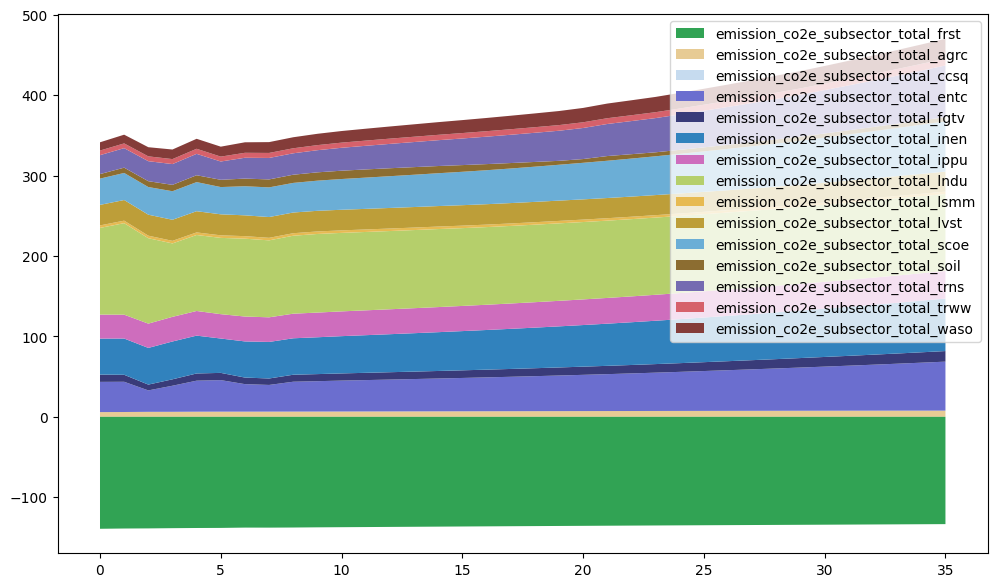

In [82]:
df_wide[df_wide[ssp.key_strategy].isin([0])][fields_subsector_emission_total]

import sisepuede.plotting.plots as spp

fig, ax = plt.subplots(figsize = (12, 7))
spp.plot_emissions_stack(
    df_base_run,
    matt,
    figtuple = (fig, ax, ),
)
ax.legend(loc = "upper right")

<Axes: >

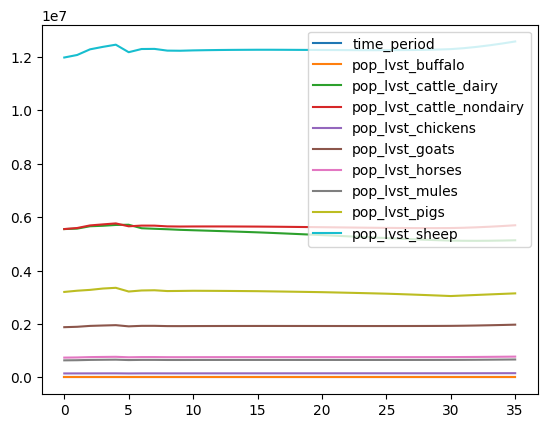

In [95]:
modvar_lvst_pop = matt.get_variable("Livestock Head Count")
df_pop = modvar_lvst_pop.get_from_dataframe(
    df_wide[df_wide[ssp.key_strategy].isin([0])],
    fields_additional = [ssp.key_time_period]
)

df_pop.plot()



<Axes: >

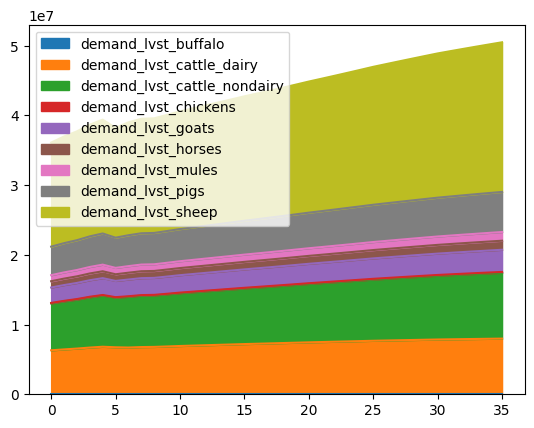

In [142]:
df_base_run_new = df_base_run.copy()
df_base_run_new["frac_gnrl_eating_red_meat"] = 1
#df_base_run["frac_gnrl_eating_red_meat"] = 1

df_out_base = ssp.models.model_afolu(df_base_run_new.drop(columns = ["strategy_id", "primary_id", "future_id", "region"]))
modvar_elast = matt.get_variable("Elasticity of Livestock Demand to GDP per Capita")
modvar_lvst_demand = matt.get_variable("Livestock Demand")

# df_out_base
# modvar_elast.get_from_dataframe(df_base_run, ).plot()
modvar_lvst_demand.get_from_dataframe(df_out_base, ).plot.area()

